### Connecting to drive



In [2]:
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive/My Drive/AN2DL/HW2


### Importing libraries and fixing randomness



In [3]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [4]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)


2.15.0


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf

In [6]:
%matplotlib widget

### Load data

In [7]:
datas = np.load('training_dataset/training_data.npy', allow_pickle=True)
indexes = np.load('training_dataset/valid_periods.npy', allow_pickle=True)
labels = np.load('training_dataset/categories.npy', allow_pickle=True)

### Inspection of the data

In [8]:
# # 'A', 'B', 'C', 'D', 'E', 'F'
# category = 'D'
# sample = np.random.randint(1000)
# window = 25

# label = labels == category

# data = datas[label][sample]
# index = indexes[label][sample]
# start = index[0]
# end = index[1]
# data = data[start:end]

# data_acf = acf(data,nlags=20)
# data_fft = np.abs(np.fft.fft(data))
# N = data.shape[0]


# fig,axs = plt.subplots(5,1,figsize = [20,10])
# axs[0].plot(data)
# axs[0].set_title('Sample {} From category {} Time and Frequency Domain'.format(sample,category))
# axs[1].plot(pd.Series(data).rolling(window,min_periods = 1).mean())
# axs[1].set_title('trend')
# axs[2].plot(data - pd.Series(data).rolling(window,min_periods = 1).mean())
# axs[2].set_title('residual')
# axs[3].plot(np.linspace(0,0.5,N//2),data_fft[:N//2])
# axs[3].set_title('fft')
# axs[4].plot(data_acf)
# axs[4].set_title('acf')
# plt.tight_layout()

### Processing data

In [9]:
data_list = []
for i in range(len(labels)):
    start, end = indexes[i]
    data_list.append({
        'datas': datas[i, start:end].astype(np.float32),
        'categories': labels[i]
    })

df = pd.DataFrame(data_list)
df = pd.concat([df, pd.get_dummies(df['categories'])], axis=1)
df = df.drop('categories', axis=1)
print(df.head())

                                               datas      A      B      C  \
0  [0.49166667, 0.5240741, 0.54444444, 0.46388888...  False  False  False   
1  [0.48, 0.5, 0.588, 0.42, 0.288, 0.3, 0.288, 0....  False  False  False   
2  [0.0074039795, 0.0, 0.017954651, 0.020916242, ...  False  False  False   
3  [1.0, 0.9296987, 0.6527977, 0.67862266, 0.5724...  False  False  False   
4  [0.20454545, 0.38636363, 0.29545453, 0.4545454...  False  False  False   

      D      E      F  
0  True  False  False  
1  True  False  False  
2  True  False  False  
3  True  False  False  
4  True  False  False  


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48000 entries, 0 to 47999
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   datas   48000 non-null  object
 1   A       48000 non-null  bool  
 2   B       48000 non-null  bool  
 3   C       48000 non-null  bool  
 4   D       48000 non-null  bool  
 5   E       48000 non-null  bool  
 6   F       48000 non-null  bool  
dtypes: bool(6), object(1)
memory usage: 656.4+ KB


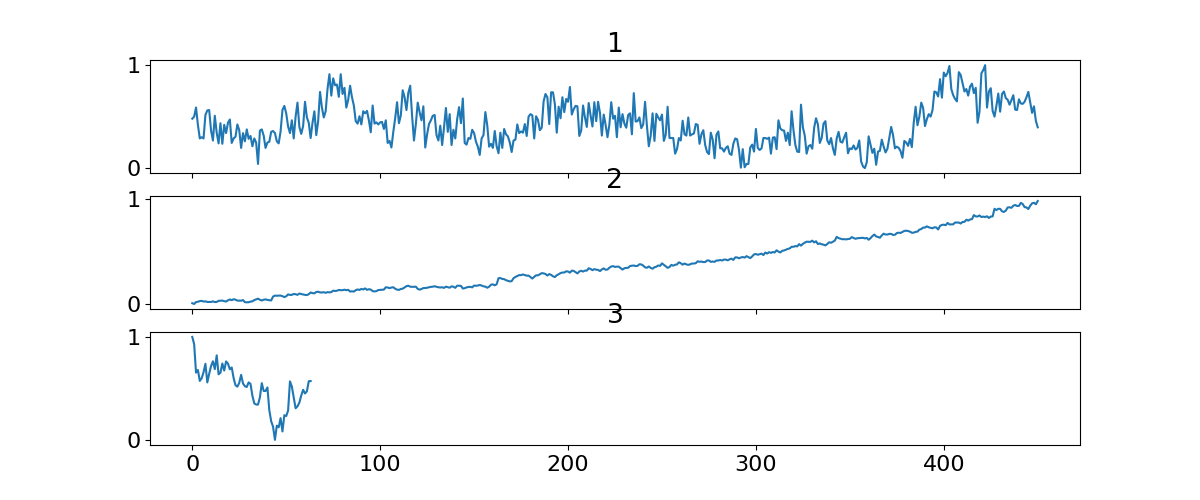

In [11]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(12,5))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

sample = [1,2,3]
inspect_dataframe(df['datas'], sample)

In [12]:
window = 100
stride = 5